In [1]:
import pandas as pd
from textblob import TextBlob

# Load news data
news_df = pd.read_csv('../data/raw_analyst_ratings.csv')

# Check for missing or malformed dates and convert
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')  # Converts invalid dates to NaT
news_df = news_df.dropna(subset=['date'])  # Drop rows with invalid dates
news_df['date'] = news_df['date'].dt.date  # Extract just the date (no time)

# Optional: Preview your dataframe
print(news_df.head())


   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

         date stock  
0  2020-06-05     A  
1  2020-06-03     A  
2  2020-05-26     A  
3  2020-05-22     A  
4  2020-05-22     A  


In [2]:
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity  # Polarity between -1 and 1

# Apply to the 'headline' or relevant text column
news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

# Aggregate daily average sentiment
daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()

In [ ]:
companies= ['AAPL', 'GOOGL']  # Example companies
stock_data_dir = '../data/'  # Directory where stock data is stored
for company in companies:
    # Load stock data
    stock_path = f'{stock_data_dir}{company}_historical_data.csv'
    stock_df = pd.read_csv(stock_path)

    # Clean column names
    stock_df.columns = stock_df.columns.str.strip()
    stock_df.rename(columns={'Date': 'date'}, inplace=True)

    # Parse date
    stock_df['date'] = pd.to_datetime(stock_df['date'], errors='coerce').dt.date

    # Compute daily return
    stock_df.sort_values('date', inplace=True)
    stock_df['daily_return'] = stock_df['Close'].pct_change()

    # Drop NaNs
    stock_df = stock_df.dropna(subset=['daily_return'])

    # Merge with sentiment
    merged_df = pd.merge(stock_df[['date', 'daily_return']], daily_sentiment, on='date', how='inner')
    merged_df['company'] = company

    # Pearson correlation
    correlation = merged_df['sentiment'].corr(merged_df['daily_return'])
    print(f'{company} - Pearson Correlation: {correlation:.4f}')

    all_results.append((company, correlation, merged_df))


AAPL - Pearson Correlation: -0.0020


NameError: name 'all_results' is not defined

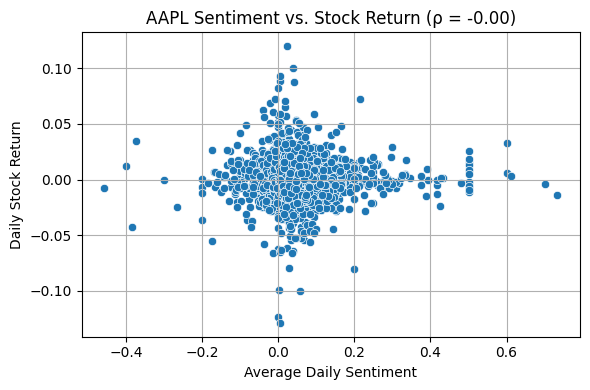

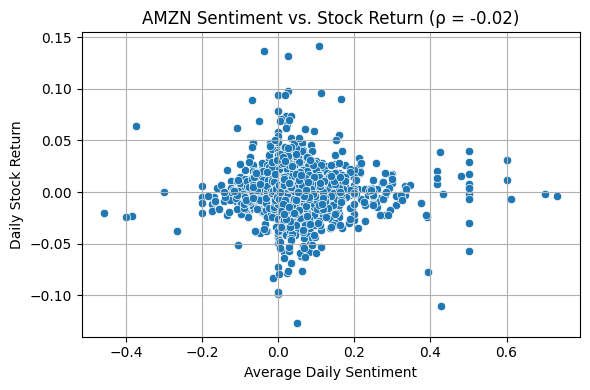

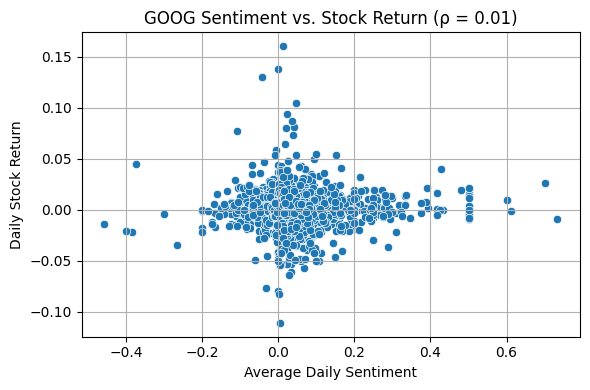

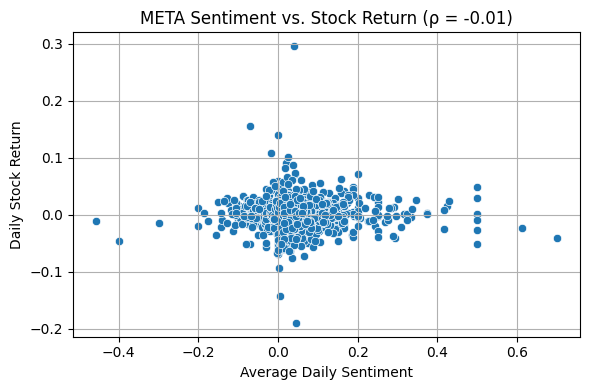

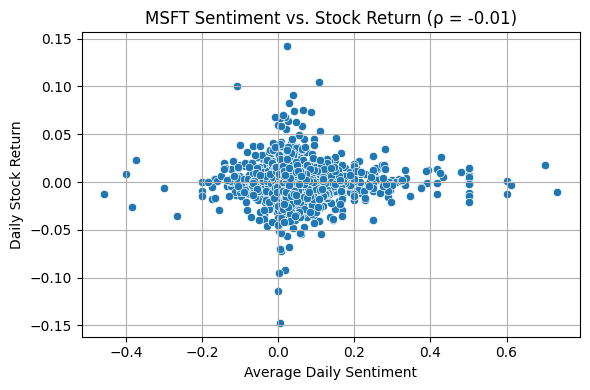

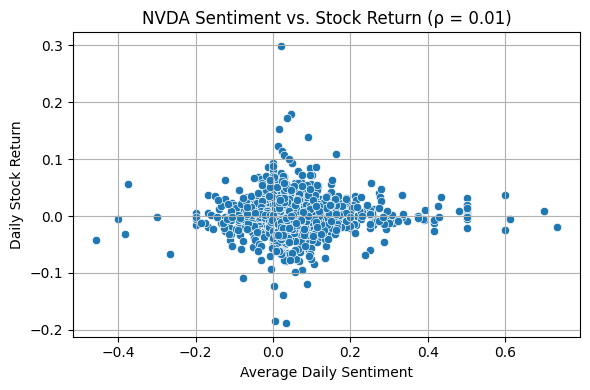

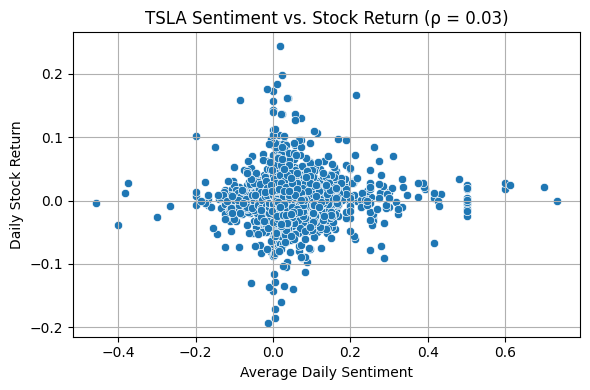

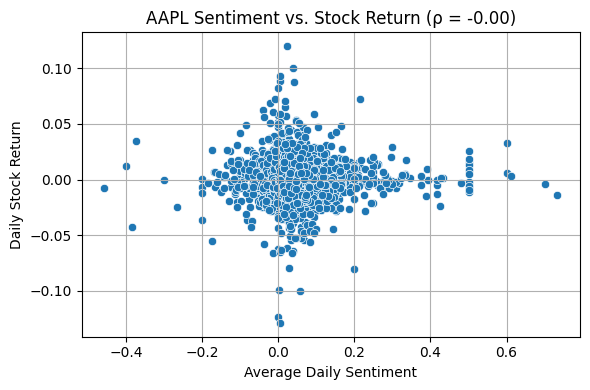

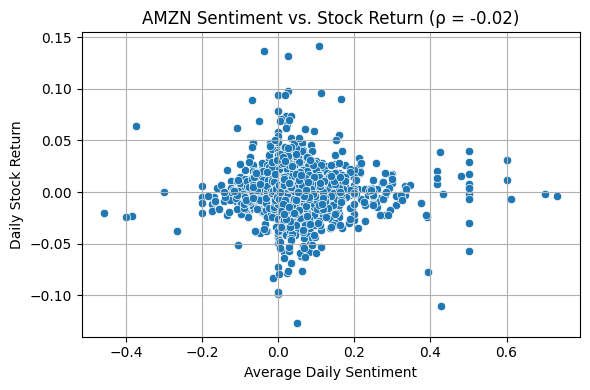

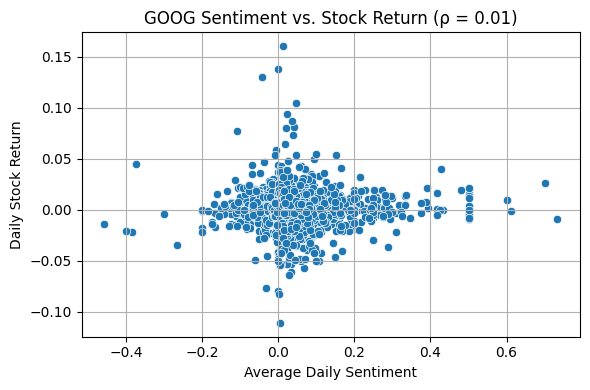

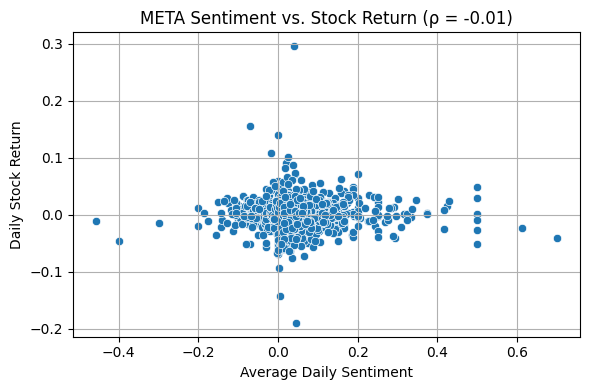

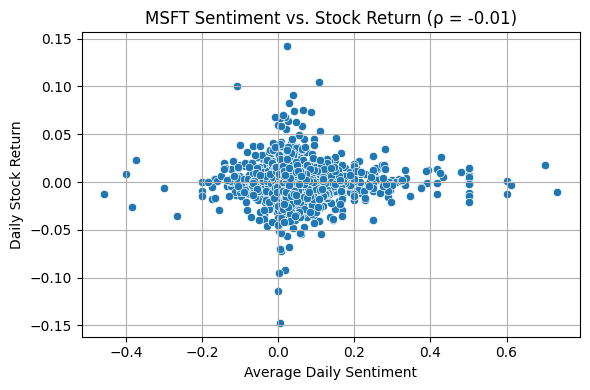

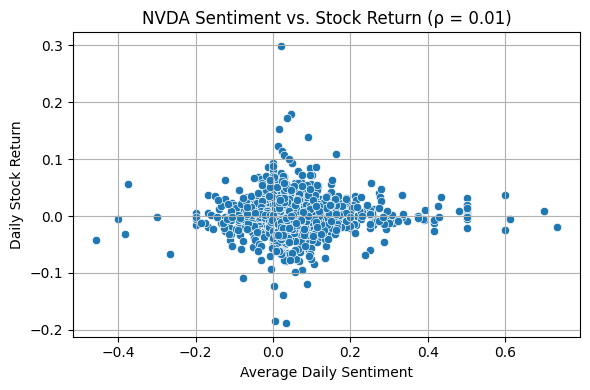

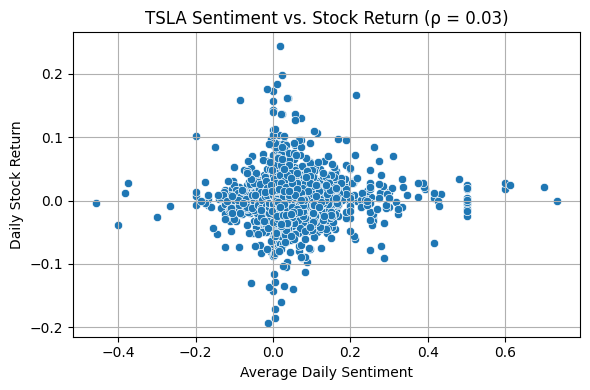

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize one or all
for company, correlation, df in all_results:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x='sentiment', y='daily_return')
    plt.title(f'{company} Sentiment vs. Stock Return (ρ = {correlation:.2f})')
    plt.xlabel('Average Daily Sentiment')
    plt.ylabel('Daily Stock Return')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Combine all merged data for export
combined_df = pd.concat([df for _, _, df in all_results], ignore_index=True)
combined_df.to_csv('../data/sentiment_stock_correlation.csv', index=False)